In [1]:
from openai import OpenAI #official SDK's OpenAi is the direct line to the API giving complete control over low-level calls
import os
import docx
import pdfplumber
import subprocess
import config
from langchain_openai import ChatOpenAI #chat model wrapper for agent's main model , to handel agent's regular routine
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode # pre-built langgraph node that executes tools when the model asks for them and pipes the result back into the conversation state
from langgraph.graph import START ,StateGraph # START is not a node , its just the flow's starting point
from langgraph.prebuilt import tools_condition # tools_condition is a helper that examines the assistant's last message to determine if we need to run tools or proceed to the end
from IPython.display import Image, display

In [2]:
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

In [3]:
# connects local environment to langsmith projects, re run the code
os.environ ["LANGSMITH_TRACING"]="true"
os.environ ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ ["LANGSMITH_API_KEY"]="<key>"
os.environ ["LANGSMITH_PROJECT"]= "ReAct Jo-bHelper Agent"

In [4]:
llm = ChatOpenAI(model="gpt-4.1")

In [5]:
@tool
def extract_cv_text(file_path:str)->str:
    """Extracts the text content from a CV file in pdf , doc  or docx format. The CV must be in the same folder as this notebook is in.
    Args:
    file_path(str): The local file path to CV document.
    Returns:
    str: The extracted text from the CV or an error message if the format is not supported or cannot be read 
    """
    ext = os.path.split(file_path)[-1].lower()

    if ".docx" in ext:
        try:
            doc = docx.Document(file_path)
            text = [para.text for para in doc.paragraph]
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading the .doc file: {e}"

    elif ".pdf" in ext:
        try:
            text = []
            with pdfplumber.open(file_path) as pdf:
                for page in pdf.pages:
                    page_text = page.extract_text()
                    if page_text:
                        text.append(page_text)
            return '\n'.join(text)
        except Exception as e :
            return f"Error reading the .pdf file: {e}"

    elif ".doc" in ext:
        try:
            temp_docx = file_path + ".temp.docx"
            subprocess.run(['soffice','--headless','--convert-to','docx','--outdir',os.path.dirname(file_path),file_path],check = True)

            doc = docx.Document(os.path.splitext(file_path)[0] + ".docx")
            text = [para.text for para in doc.paragraphs]
            os.remove(os.path.splitext(file_path)[0] + ".docx")
            return '\n'.join(text)
        except Exception as e:
            return f"Error reading .doc file: {e}"
        else:
            return "Unspported file format! Please use .pdf , .docx or .doc. "

In [6]:
@tool
def job_posting_tool(job_link: str)->str:
    """Extracts the structured information from a job posting at the provided URL.
    Args:
    job_link (str): The URL of the job posting.
    Returns:
    str: Astructured summary of the job posting's key details.
    """
    completion = client.chat.completions.create(
        model = "gpt-4o-search-preview",
        web_search_options = {
            "search_context_size": "medium",
        },
        messages = [
        {
            "role":"user",
            "content":""""
            You are a helpful tool that visits the following job posting and carefully read its contents.  
                Summarize the key details in a clear and concise format, including:
                Visit the provided job posting link, read it thoroughly, and extract and summarize all key information. Include:
                - Job title
                - Company name
                - Location
                - Employment type (full-time, part-time, contract, etc.)
                - Salary or compensation (if available)
                - Required qualifications/skills
                - Primary responsibilities
                - Benefits offered
                - Application instructions
                - Posting date (if available)
    
                Format
                - Respond with a clear, structured bullet-point list.
                - Use exact factual information from the posting, no rewording beyond making it concise.
                - If the posting is missing, inaccessible, or contains no job details, respond with:
                "Job posting unavailable or contains no job details."
    
                Do's 
                - Ensure all extracted details are accurate and directly taken from the posting.
                - Keep descriptions short, professional, and easy to scan.
                - Use consistent formatting for all fields (e.g., “Job Title: …”).  
                Don'ts
                - Do not include filler language, speculation, or personal opinions.
                - Do not rewrite or interpret details—only report factual information from the posting.
                """,
        },{
            "role":"system",
            "content": f"Visit this job posting and extract details:\n{job_link}"
            
        }
        ],
    )
    
    return (completion.choices[0].message.content)

In [7]:
tools = [job_posting_tool,extract_cv_text]
tool_node = ToolNode(tools=tools)

In [8]:
llm_with_tools = llm.bind_tools(tools)

In [9]:
# The State , messages state 
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage,SystemMessage #(userinput,prompt)

In [10]:
sys_msg = SystemMessage(content="""
You are an expert career assistant that helps the user with questions related to jobs, careers, and applications.

Your key capabilities:
- You have access to the user's CV and can read its contents using the `extract_cv_text` tool.
- You can look up and extract details from job postings using the `job_posting_tool`.
- You can compare the user's CV against one or more job postings to determine suitability and provide tailored advice.
- You can suggest improvements to the CV for better alignment with target roles.

When answering:
1. First, think step-by-step about the user's request.
2. If the task requires reading the CV, call the CV extraction tool before answering.
3. If the task involves evaluating job postings, call the job posting tool to gather accurate information before answering.
4. Compare and reason about the information before providing your final response.

Response format:
- Be clear, concise, and structured with bullet points or numbered lists.
- Use section headers when possible (e.g., "Strengths", "Weaknesses", "Recommendations").
- Support your statements with evidence from the CV or job postings.
- Avoid vague language—be specific and factual.

Constraints:
- Do not invent or guess details about the user's experience or job postings.
- Only use information available in the CV, job postings, or provided context.
- Keep your tone professional, friendly, and supportive.


""")

In [18]:
# func recieves the current conversation as input, the state contains every msg so far in the chat,
# the next part involves building the complete list of messages to send to the model
# 1. insert system message with prompt that was defined earlier so the model sees the instructions and role before any user message 
# 2. append all the messages from the current conversation, calls the model that has been bound to tools 
# 3. return a single key:messages, containing a list of the model's latest replies

# (system prompt + conversation) -> LLM -> New Message
from langsmith import traceable

@traceable(name="Job Posting Tool") # LangSmith records the trace , any function that calls an LLM
def assistant(state: MessagesState):
    return{"messages":[llm_with_tools.invoke([sys_msg]+ state["messages"])]}

In [19]:
from langgraph.graph import START ,StateGraph # START is not a node , its just the flow's starting point
from langgraph.prebuilt import tools_condition # tools_condition is a helper that examines the assistant's last message to determine if we need to run tools or proceed to the end
from IPython.display import Image, display # rendering a diagram of the garph, to visualize the wiring later

In [20]:
# build the graph builder and specify the type of state we're using
builder = StateGraph(MessagesState) #MessagesState a list of messages, which serves as the agent's short term memory
builder.add_node("assistant",assistant) # agent's brain
builder.add_node("tools",ToolNode(tools)) #collection of tools 

# agent starts here 

# START doesn't perform any logic ; it simply marks the point where execution begins
# since there is nothing to run at the start , we don't define a node,laggraph jumps from start to first real node

builder.add_edge(START,"assistant")
# The tool'c condition inspectes the assistant's latest output , if the model asks to call a tool it routes to tools ; otherwise , it routes to the END
builder.add_conditional_edges("assistant",tools_condition)

# create a loop to connect the tools back to the assistant
builder.add_edge("tools","assistant")

# compile the blueprint into a runnable graph, validates nodes and edges, sets up the routing logic and returns the callable graph object to run 
react_graph = builder.compile()

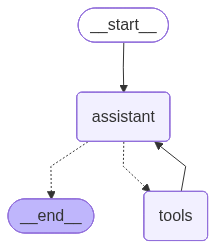

In [21]:
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [22]:
# adding memory

In [23]:
# every time it starts fresh and forgets anything said before 
# LangGraph check pointer : storage system that tracks the graph's state between runs (agent's short time memory)

In [24]:
from langgraph.checkpoint.memory import MemorySaver
memory = MemorySaver()
# compile in checkpointer, so that It saves and retrieves the state of the graph across multiple runs, allowing the agent to have short-term memory.
react_graph_memory = builder.compile(checkpointer=memory)
# stable threadID -> which conversation to keep a track of
config = {"configurable":{"thread_id" : "1"}}

In [25]:
messages = [HumanMessage(content="""
                        Can yo take a look at my CV at the location 'Anagha.pdf' and these 3 job applications and tell me which one is the modt suitable for my expiriance
                        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
                        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
                        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'
                        """)]

In [26]:
#result = react_graph.invoke({"messages": messages})
result = react_graph_memory.invoke({"messages":messages},config)

In [27]:
for m in result['messages']:
    m.pretty_print()

================================ Human Message =================================


                        Can yo take a look at my CV at the location 'Anagha.pdf' and these 3 job applications and tell me which one is the modt suitable for my expiriance
                        'https://www.indeed.com/viewjob?jk=247e94f9a28c544f&tk=1isdf5na1h72t810&from=serp&vjs=3',
                        'https://www.indeed.com/viewjob?jk=744686732444f370&tk=1isns1midj72r8b4&from=serp&vjs=3',
                        'https://www.indeed.com/viewjob?jk=01e2f371f220e42a&tk=1isns1midj72r8b4&from=serp&vjs=3'
                        
================================== Ai Message ==================================
Tool Calls:
  extract_cv_text (call_tA3ElXV6fphc4b39FKskiRon)
 Call ID: call_tA3ElXV6fphc4b39FKskiRon
  Args:
    file_path: Anagha.pdf
  job_posting_tool (call_aEXQ7hexL5egNImjbI4sgHVt)
 Call ID: call_aEXQ7hexL5egNImjbI4sgHVt
  Args:
    job_link: https://www.indeed.com/viewjob?jk=247e94f9a28c544f

In [28]:
# without changing the thread_id send a follow up question
messgages = [HumanMessage(content="""
                        For which job am I least suitable?
                        """)]

In [21]:
# conecting to LangSmith

In [22]:
# evaluation
# Duration of each run 
# tools invoked 
# number of tokens used 

# connects local environment to langsmith projects, re run the code
os.environ ["LANGSMITH_TRACING"]="true"
os.environ ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ ["LANGSMITH_API_KEY"]="<key "
os.environ ["LANGSMITH_PROJECT"]= "ReAct Jo-bHelper Agent"
from langsmith import tracable